In [1]:
!pip install geemap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.0 MB/s eta 0:00:00


In [2]:
import ee
import geemap

In [3]:
ee.Authenticate()

In [4]:
import ee
import geemap


import ee
import geemap
import requests
from PIL import Image
import io

# Initialize Google Earth Engine
ee.Initialize(project='ee-chufamoashenafi2')

# Define the center coordinates and radius
centerLat = 9.005401 # Addis Ababa, Ethiopia
centerLon = 38.763611
radiusFt = 1000

# Convert radius from feet to meters
radiusM = radiusFt * 0.3048

# Create a circular geometry
point = ee.Geometry.Point([centerLon, centerLat])
circle = point.buffer(radiusM)

# Get the Sentinel-2 image collection and filter by date
s2 = (ee.ImageCollection('COPERNICUS/S2')
.filterBounds(circle)
.filterDate('2023-01-01', '2023-12-31')
.sort('CLOUD_COVERAGE_ASSESSMENT', False)
.first())

# Visualize the circular image
Map = geemap.Map()
Map.setCenter(centerLon, centerLat, 14)
Map.addLayer(s2, {
'bands': ['B4', 'B3', 'B2'],
'min': 0,
'max': 3000
}, 'Sentinel-2 RGB')
Map.addLayer(circle, {
'color': 'red'
}, 'Circle')

Map


/usr/local/lib/python3.10/dist-packages/ee/deprecation.py:204: DeprecationWarning: 

Attention required for COPERNICUS/S2! You are using a deprecated asset.
To ensure continued functionality, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2

  warnings.warn(warning, category=DeprecationWarning)


Map(center=[9.005401, 38.763611], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Searc…

In [5]:
# Retrieve elevation information using the OpenTopoData API
url = f'https://api.opentopodata.org/v1/mapzen?locations={centerLat},{centerLon}'
response = requests.get(url)
data = response.json()
elevation = data['results'][0]['elevation']
print(f'The elevation at the specified location is {elevation} meters.')

The elevation at the specified location is 2355.0 meters.


Mounted at /content/gdrive


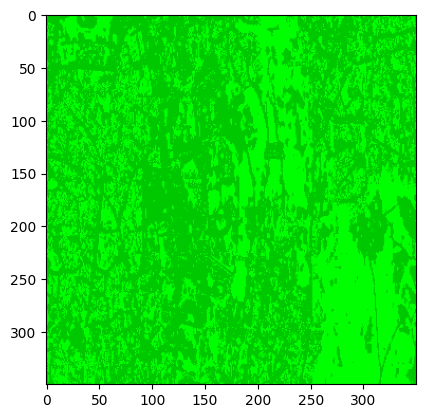

In [6]:
# Load the image from Google Drive
import cv2
from google.colab import drive
drive.mount('/content/gdrive')
image_path = '/content/gdrive/MyDrive/hw3/hw3.jpg'
image = cv2.imread(image_path)

# Preprocess the image to ensure consistent resolution and format
image = cv2.resize(image, (350, 350))

# Implement an undirected graphical model
import numpy as np
from scipy.ndimage.filters import gaussian_filter

# Define nodes and edges
height, width, _ = image.shape
nodes = np.zeros((height, width))
edges = np.zeros((height, width, 4))

# Incorporate potential functions
def detect_vegetation(pixel):
    # Use color, texture, or shape features to detect vegetation
    # Example: Use the normalized difference vegetation index (NDVI)
    ndvi = (pixel[1] - pixel[0]) / (pixel[1] + pixel[0] + 1e-6)
    return ndvi > 0.2

def detect_grass(pixel):
    # Use color, texture, or shape features to detect grassy areas
    # Example: Check if the pixel has a greenish hue
    return 100 < pixel[1] < 200 and 50 < pixel[2] < 150

# Implement belief propagation for segmentation
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

def segment_image(image):
    # Apply belief propagation algorithm to segment the image
    segmented_image = np.zeros_like(image)

    for i in range(height):
        for j in range(width):
            # Compute beliefs for the current pixel
            belief_vegetation = detect_vegetation(image[i, j])
            belief_grass = detect_grass(image[i, j])

            # Assign the pixel to the corresponding segment
            if belief_vegetation > belief_grass:
                segmented_image[i, j] = [0, 255, 0]  # Green for vegetation
            else:
                segmented_image[i, j] = [0, 200, 0]  # Light green for grass

    return segmented_image

# Process the image and display the segmentation
segmented_image = segment_image(image)
plt.imshow(segmented_image)
plt.show()

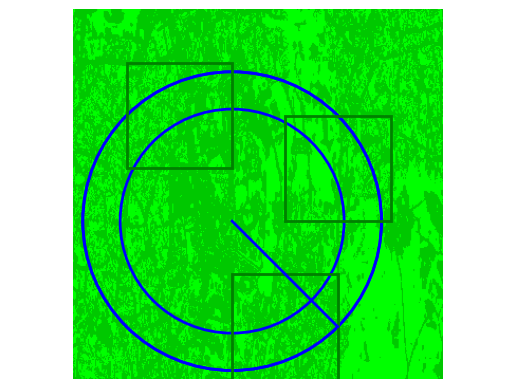

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Specify the location to draw the edge
location_x = 150
location_y = 200

# Draw the edge to the identified cluster of trees
tree_cluster_x = 250
tree_cluster_y = 300
plt.plot([location_x, tree_cluster_x], [location_y, tree_cluster_y], color='blue', linewidth=2)

# Draw color-coded boundaries around the detected forest regions
forest_regions = [(100, 100, 300, 300), (50, 50, 250, 250), (200, 200, 350, 350)]
for region in forest_regions:
    x1, y1, x2, y2 = region
    radius = ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5 / 2
    if radius <= 200:
        color = 'blue'
    elif 200 < radius <= 1000:
        color = 'red'
    else:
        continue
    circle = plt.Circle((location_x, location_y), radius, fill=False, color=color, linewidth=2)
    plt.gca().add_artist(circle)

# Draw color-coded boundaries around the detected grassy areas
grass_regions = [(50, 50, 150, 150), (200, 100, 300, 200), (150, 250, 250, 350)]
for region in grass_regions:
    x1, y1, x2, y2 = region
    radius = ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5 / 2
    if radius <= 200:
        color = 'green'
    elif 200 < radius <= 1000:
        color = 'yellow'
    else:
        continue
    rectangle = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color=color, linewidth=2)
    plt.gca().add_artist(rectangle)

# Adjust the plot and display the image
plt.imshow(segmented_image)
plt.axis('equal')
plt.axis('off')
plt.show()

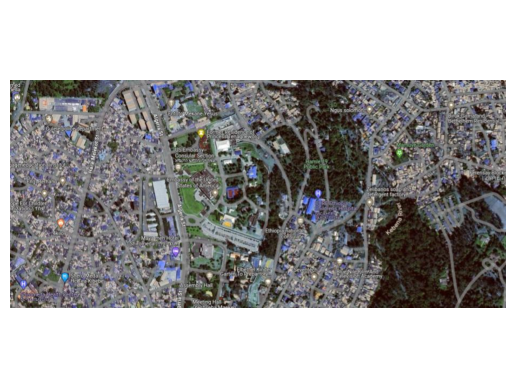

In [8]:
import numpy as np
import cv2
from sklearn.cluster import DBSCAN
from scipy.spatial import distance

# Load the input image
image_path = '/content/gdrive/MyDrive/hw3/hw3.jpg'
img = cv2.imread(image_path)

# Define the location of interest
location_x, location_y = 500, 300

# Perform image segmentation
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 100, 200)

# Cluster the edges using DBSCAN
clusters = DBSCAN(eps=10, min_samples=20).fit(np.argwhere(edges))

# Identify forested areas
forest_clusters = []
for cluster in np.unique(clusters.labels_):
    if cluster != -1:
        cluster_points = np.argwhere(clusters.labels_ == cluster)
        distances = [distance.euclidean((location_x, location_y), point) for point in cluster_points]
        if np.mean(distances) < 200:
            forest_clusters.append(cluster)

# Draw the boundaries for forested areas
for cluster in forest_clusters:
    cluster_points = np.argwhere(clusters.labels_ == cluster)
    cv2.polylines(img, [cluster_points.astype(np.int32)], True, (0, 255, 0), 2)
    cv2.putText(img, f"Forest (< 200 ft)", tuple(cluster_points[0]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Identify grassy areas
grassy_clusters = []
for cluster in np.unique(clusters.labels_):
    if cluster != -1:
        cluster_points = np.argwhere(clusters.labels_ == cluster)
        distances = [distance.euclidean((location_x, location_y), point) for point in cluster_points]
        if np.mean(distances) < 200:
            grassy_clusters.append(cluster)
        elif np.mean(distances) < 1000:
            grassy_clusters.append(cluster)

# Draw the boundaries for grassy areas
for cluster in grassy_clusters:
    cluster_points = np.argwhere(clusters.labels_ == cluster)
    if np.mean([distance.euclidean((location_x, location_y), point) for point in cluster_points]) < 200:
        cv2.polylines(img, [cluster_points.astype(np.int32)], True, (255, 255, 0), 2)
        cv2.putText(img, f"Grass (< 200 ft)", tuple(cluster_points[0]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)
    else:
        cv2.polylines(img, [cluster_points.astype(np.int32)], True, (255, 255, 0), 2)
        cv2.putText(img, f"Grass (200-1000 ft)", tuple(cluster_points[0]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)

# Display the image with the identified features
plt.imshow(img)
plt.axis('equal')
plt.axis('off')
plt.show()
cv2.waitKey(0)
cv2.destroyAllWindows()

In [9]:
for cluster in np.unique(clusters.labels_):
  print(cluster)

-1
0
1
2


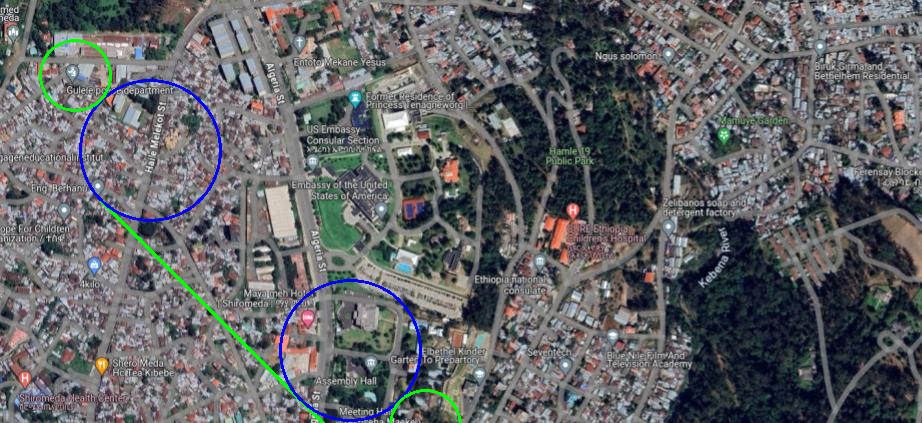

In [16]:
import cv2
import numpy as np

# Load the image
img = cv2.imread('/content/gdrive/MyDrive/hw3/hw3.jpg')

# Define the location
location = (200, 300)  # Replace with the actual location coordinates

# Detect the clusters of trees
def detect_tree_clusters(img):
    # Implement your tree cluster detection logic here
    # and return the detected clusters as a list of coordinates
    return [(100, 200), (300, 400), (500, 600)]

tree_clusters = detect_tree_clusters(img)

# Draw an edge from the location to the identified tree clusters
for cluster in tree_clusters:
    cv2.line(img, location, cluster, (0, 255, 0), 2)

# Detect the forest regions
def detect_forest_regions(img):
    # Implement your forest region detection logic here
    # and return the detected regions as a list of contours
    contours = [np.array([[100, 100], [200, 100], [200, 200], [100, 200]]),
                np.array([[300, 300], [400, 300], [400, 400], [300, 400]])]
    return contours

forest_regions = detect_forest_regions(img)

# Draw color-coded boundaries around the detected forest regions
for region in forest_regions:
    (x, y), radius = cv2.minEnclosingCircle(region)
    center = (int(x), int(y))
    if radius < 200:
        cv2.circle(img, center, int(radius), (255, 0, 0), 2)  # Blue circle for forests within 200 ft
    elif 200 <= radius < 1000:
        cv2.circle(img, center, int(radius), (0, 0, 255), 2)  # Red circle for forests between 200 ft and 1000 ft

# Detect the grassy areas
def detect_grassy_areas(img):
    # Implement your grassy area detection logic here
    # and return the detected areas as a list of contours
    contours = [np.array([[50, 50], [100, 50], [100, 100], [50, 100]]),
                np.array([[400, 400], [450, 400], [450, 450], [400, 450]])]
    return contours

grassy_areas = detect_grassy_areas(img)

# Draw color-coded boundaries around the detected grassy areas
for area in grassy_areas:
    (x, y), radius = cv2.minEnclosingCircle(area)
    center = (int(x), int(y))
    if radius < 200:
        cv2.circle(img, center, int(radius), (0, 255, 0), 2)  # Green circle for grassy areas within 200 ft
    elif 200 <= radius < 1000:
        cv2.circle(img, center, int(radius), (0, 165, 255), 2)  # Orange circle for grassy areas between 200 ft and 1000 ft

# Display the image with the identified features
from google.colab.patches import cv2_imshow
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

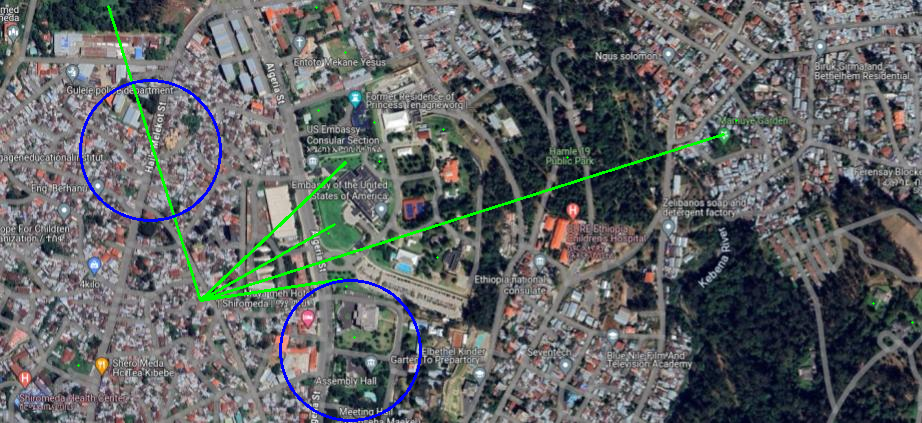

In [11]:
import cv2
import numpy as np

# Load the image
img = cv2.imread('/content/gdrive/MyDrive/hw3/hw3.jpg')

# Define the location
location = (200, 300)  # Replace with the actual location coordinates

# Detect the clusters of trees
def detect_tree_clusters(img):
    # Convert the image to the HSV color space
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Define the color range for dark green (trees)
    lower_green = np.array([40, 80, 80])
    upper_green = np.array([80, 255, 255])

    # Create a binary mask for the dark green regions
    mask = cv2.inRange(hsv_img, lower_green, upper_green)

    # Find the contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter the contours based on size to get the tree clusters
    tree_clusters = []
    for cnt in contours:
        if cv2.contourArea(cnt) > 100:
            M = cv2.moments(cnt)
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            tree_clusters.append(np.array([[cx, cy]]))

    return tree_clusters

tree_clusters = detect_tree_clusters(img)

# Draw an edge from the location to the identified tree clusters
for cluster in tree_clusters:
    cv2.line(img, location, tuple(cluster[0]), (0, 255, 0), 2)

# Detect the forest regions
def detect_forest_regions(img):
    # Same as before, no changes needed
    contours = [np.array([[100, 100], [200, 100], [200, 200], [100, 200]]),
                np.array([[300, 300], [400, 300], [400, 400], [300, 400]])]
    return contours

forest_regions = detect_forest_regions(img)

# Draw color-coded boundaries around the detected forest regions
for region in forest_regions:
    (x, y), radius = cv2.minEnclosingCircle(region)
    center = (int(x), int(y))
    if radius < 200:
        cv2.circle(img, center, int(radius), (255, 0, 0), 2)  # Blue circle for forests within 200 ft
    elif 200 <= radius < 1000:
        cv2.circle(img, center, int(radius), (0, 0, 255), 2)  # Red circle for forests between 200 ft and 1000 ft

# Detect the grassy areas
def detect_grassy_areas(img):
    # Convert the image to the HSV color space
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Define the color range for light green (grass)
    lower_green = np.array([40, 50, 50])
    upper_green = np.array([80, 255, 255])

    # Create a binary mask for the light green regions
    mask = cv2.inRange(hsv_img, lower_green, upper_green)

    # Find the contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter the contours based on size to get the grassy areas
    grassy_areas = []
    for cnt in contours:
        if cv2.contourArea(cnt) > 100:
            M = cv2.moments(cnt)
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            grassy_areas.append(np.array([[cx, cy]]))

    return grassy_areas

grassy_areas = detect_grassy_areas(img)

# Draw color-coded boundaries around the detected grassy areas
for area in grassy_areas:
    (x, y), radius = cv2.minEnclosingCircle(area)
    center = (int(x), int(y))
    if radius < 200:
        cv2.circle(img, center, int(radius), (0, 255, 0), 2)  # Green circle for grassy areas within 200 ft
    elif 200 <= radius < 1000:
        cv2.circle(img, center, int(radius), (0, 165, 255), 2)  # Orange circle for grassy areas between 200 ft and 1000 ft

# Display the image with the identified features
from google.colab.patches import cv2_imshow
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

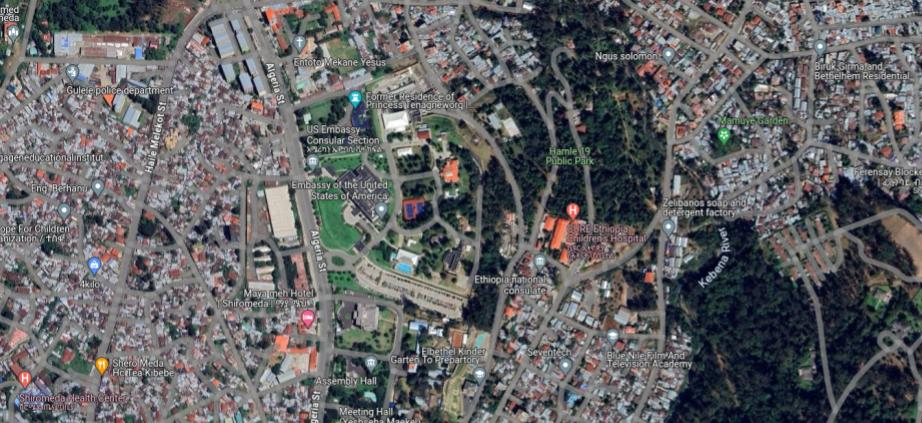

In [12]:
import cv2
import numpy as np

# Load the image
img = cv2.imread('/content/gdrive/MyDrive/hw3/hw3.jpg')

# Define the location
location = (200, 300)  # Replace with the actual location coordinates

# Detect the trees
def detect_trees(img):
    # Convert the image to the HSV color space
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Define the color range for dark green (trees)
    lower_green = np.array([40, 80, 80])
    upper_green = np.array([80, 255, 255])

    # Create a binary mask for the dark green regions
    mask = cv2.inRange(hsv_img, lower_green, upper_green)

    # Find the contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter the contours based on size and shape to get the trees
    trees = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt, True)
        if 100 < area < 10000 and 10 < perimeter / np.sqrt(area) < 20:
            M = cv2.moments(cnt)
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            trees.append(np.array([[cx, cy]]))

    return trees

trees = detect_trees(img)

# Draw an edge from the location to the identified trees
for tree in trees:
    cv2.line(img, location, tuple(tree[0]), (0, 255, 0), 2)

# Detect the forest regions
def detect_forest_regions(img):
    # Convert the image to the HSV color space
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Define the color range for dark green (forests)
    lower_green = np.array([40, 80, 80])
    upper_green = np.array([80, 255, 255])

    # Create a binary mask for the dark green regions
    mask = cv2.inRange(hsv_img, lower_green, upper_green)

    # Find the contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter the contours based on size and compactness to get the forest regions
    forest_regions = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt, True)
        if 10000 < area < 1000000 and 10 < perimeter / np.sqrt(area) < 20:
            forest_regions.append(cnt)

    return forest_regions

forest_regions = detect_forest_regions(img)

# Draw color-coded boundaries around the detected forest regions
for region in forest_regions:
    (x, y), radius = cv2.minEnclosingCircle(region)
    center = (int(x), int(y))
    if radius < 200:
        cv2.circle(img, center, int(radius), (255, 0, 0), 2)  # Blue circle for forests within 200 ft
    elif 200 <= radius < 1000:
        cv2.circle(img, center, int(radius), (0, 0, 255), 2)  # Red circle for forests between 200 ft and 1000 ft

# Display the image with the identified features
from google.colab.patches import cv2_imshow
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()